In [268]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
import numpy as np
from scipy.interpolate import UnivariateSpline
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet

In [269]:
data = pd.read_csv('../Downloads/BI_Analyst_Exercise_V1_DataSet.csv', thousands=',')

In [270]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7911 entries, 0 to 7910
Data columns (total 6 columns):
Month_Ending          7911 non-null object
Segment               7911 non-null object
City                  7907 non-null object
Product               7911 non-null object
Miles                 7911 non-null int64
Reported_Accidents    7911 non-null int64
dtypes: int64(2), object(4)
memory usage: 370.9+ KB


In [271]:
#Check for null values in the data before analysis. Looks like there are 4 rows with no reported city.
data.isnull().sum()

Month_Ending          0
Segment               0
City                  4
Product               0
Miles                 0
Reported_Accidents    0
dtype: int64

In [272]:
#let's examine those rows
data[data['City'].isnull()]

,Month_Ending,Segment,City,Product,Miles,Reported_Accidents
2812,4/30/16,Segment C,NaN,Product 7,1,0
3198,5/31/16,Segment C,NaN,Product 7,2,0
3459,6/30/16,Segment C,NaN,Product 7,11,0
4577,7/31/16,Segment C,NaN,Product 7,12,0


In [273]:
#Since there are only 4 rows and all of the have not reported accidents, I belive it is safe to drop these rows
#Let's clean up our dataset by first removing these rows
data = data.dropna()

In [274]:
data.isnull().sum()

Month_Ending          0
Segment               0
City                  0
Product               0
Miles                 0
Reported_Accidents    0
dtype: int64

In [275]:
#converting MOnth_Ending to DateTime object
data['Month_Ending'] = pd.to_datetime(data['Month_Ending'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7907 entries, 0 to 7910
Data columns (total 6 columns):
Month_Ending          7907 non-null datetime64[ns]
Segment               7907 non-null object
City                  7907 non-null object
Product               7907 non-null object
Miles                 7907 non-null int64
Reported_Accidents    7907 non-null int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 432.4+ KB


In [276]:
#Let's start with Segment Wise 
s = data.groupby('Segment')['Reported_Accidents'].sum().reset_index()


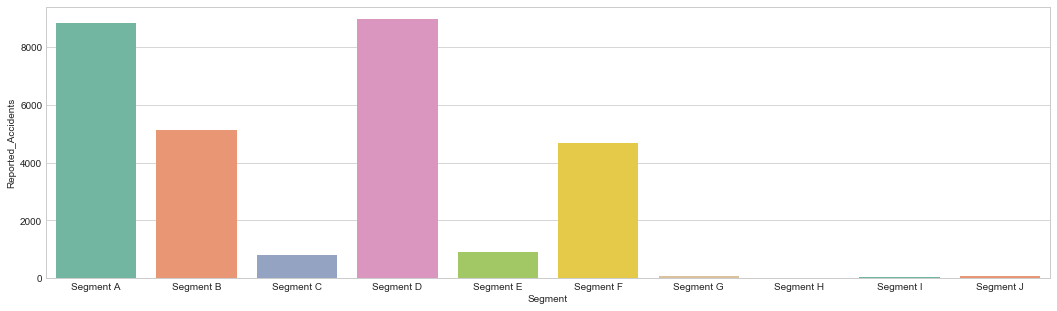

In [277]:
f, (ax1) = plt.subplots(nrows=1,ncols=1, figsize=(18,5))
sns.barplot(x='Segment', y='Reported_Accidents', data=s , palette='Set2', ax=ax1)


Looks lIke Segment D has the highest number of reported Accidents followed closely by Segment A

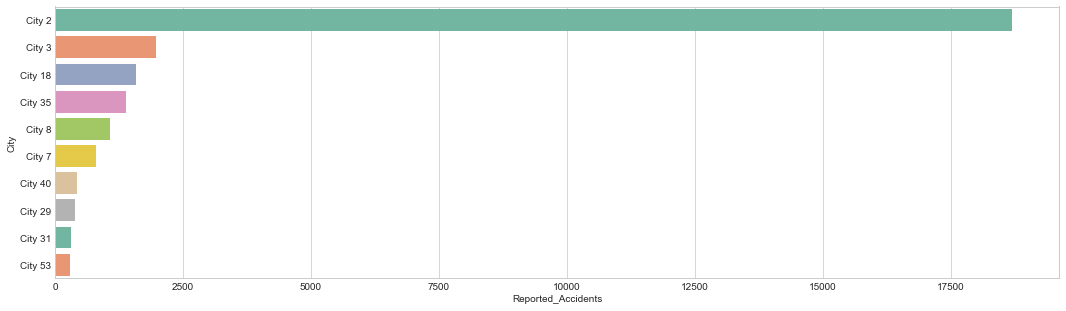

In [278]:
#Let's find out the top 10 cities with maximum number of reported accidents
c = data.groupby('City')['Reported_Accidents'].sum().reset_index()
c = c.sort_values('Reported_Accidents', ascending=False)
c[:10]
f, (ax1) = plt.subplots(nrows=1,ncols=1, figsize=(18,5))
sns.barplot(y='City', x='Reported_Accidents', data=c[:10] , palette='Set2', ax=ax1)

City 2 Has reported the highest number of accidents compared to any other city!!!

Text(0.5,1,u'Accident_rate per month')

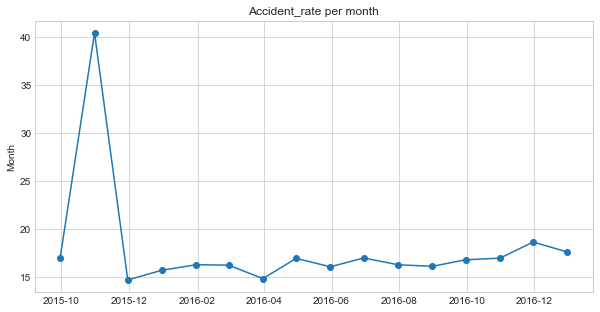

In [436]:
#Let's do some processing to forecast the accident rate in Jan 2017, 
#Here I am trying to aggregate the acc_rate for everymonth and then I will extrapolate the results

def acc_rate_month(data):
    return data['Reported_Accidents']/ data['Miles'] * 1000000
time = data.groupby('Month_Ending')[['Reported_Accidents', 'Miles']].sum().reset_index()
time =time.rename(columns={'Month_Ending':'Month'})
data2 = time.set_index('Month')
data2['Accident_rate_monthly'] = data2['Reported_Accidents']/ data2['Miles'] * 1000000
data2.drop(['Reported_Accidents','Miles'], axis=1,inplace=True)
plt.figure(figsize=(10,5))
plt.plot(data2, marker='o',)
plt.ylabel('Month')
plt.title('Accident_rate per month')

The above plot shows the trend of acc rate over the months from the data

In [423]:
#Building a prophet model to perform Time series analysis and forecasting

model = Prophet()
data2 = data2.reset_index()
data2 = data2.rename(columns={'Month':'ds','Accident_rate_monthly':'y'})
model.fit(data2);

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.


In [427]:
future_dates = model.make_future_dataframe(periods=2, freq='MS')
future_dates.tail()

,ds
13,2016-10-31
14,2016-11-30
15,2016-12-31
16,2017-01-01
17,2017-02-01


In [428]:
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
13,2016-10-31,18.085297,10.810302,25.438901
14,2016-11-30,18.085998,10.341703,25.340762
15,2016-12-31,18.086723,10.254155,25.240306
16,2017-01-01,18.086747,10.401493,25.538446
17,2017-02-01,18.087472,10.403267,25.426805


<Heading2> <B> From the above table it can be seen that the Accident rate in Jan 2017 would be about 18.08.</B> </Heading2>

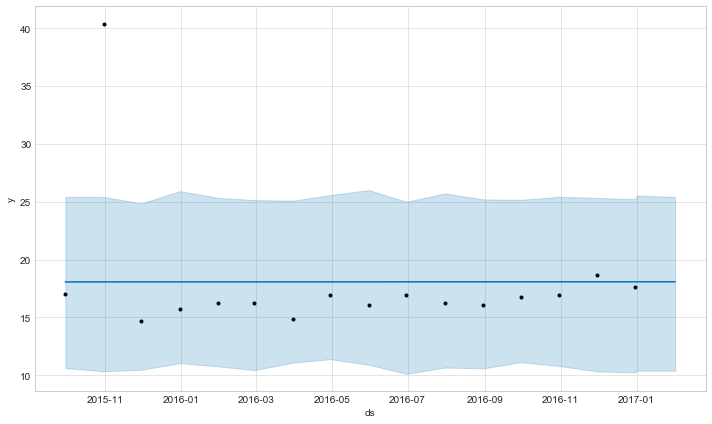

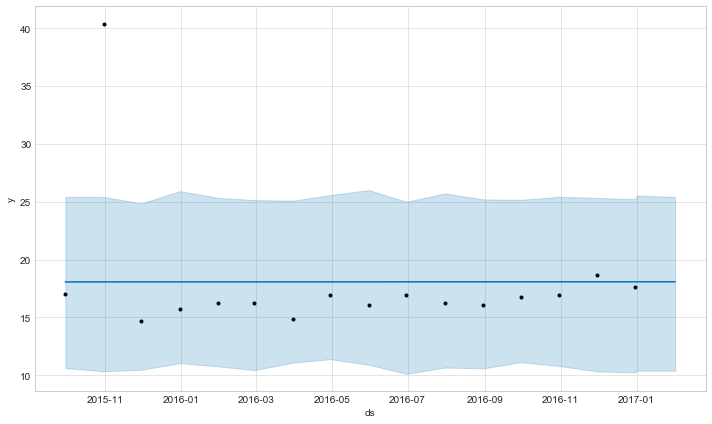

In [437]:
model.plot(forecast,
              uncertainty=True)

In [438]:
data2

,Accident_rate_monthly
Month,
2015-09-30,17.012470
2015-10-31,40.381517
2015-11-30,14.699031
2015-12-31,15.715764
2016-01-31,16.281411
2016-02-29,16.238251
2016-03-31,14.842272
2016-04-30,16.934725
2016-05-31,16.066037
